#### Importing Necessary Libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import cv2
import random

In [2]:
np.random.seed(42)

#### Data Loading and Basic EDA

In [3]:
mnist_data = fetch_openml('mnist_784', version=1, as_frame=False, parser='auto')

In [4]:
X_mnist_raw = mnist_data.data  
y_mnist_raw_str = mnist_data.target # Labels are initially strings

y_mnist = y_mnist_raw_str.astype(np.uint8)

In [5]:
print(f"Shape of X_mnist_raw (features): {X_mnist_raw.shape}") 
print(f"Shape of y_mnist (labels): {y_mnist.shape}")   
print(f"Min/Max pixel values in X_mnist_raw: {X_mnist_raw.min()}/{X_mnist_raw.max()}")
print(f"Data type of X_mnist_raw: {X_mnist_raw.dtype}")
print(f"Data type of y_mnist: {y_mnist.dtype}")

Shape of X_mnist_raw (features): (70000, 784)
Shape of y_mnist (labels): (70000,)
Min/Max pixel values in X_mnist_raw: 0/255
Data type of X_mnist_raw: int64
Data type of y_mnist: uint8


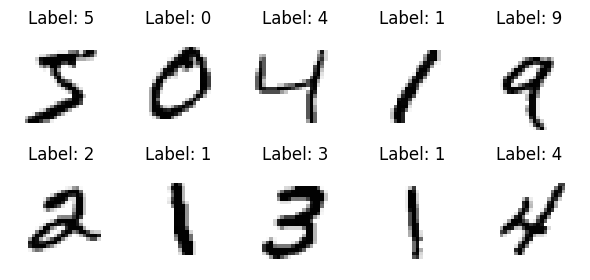

In [6]:
fig, axes = plt.subplots(2, 5, figsize=(6, 3)) 
axes = axes.flatten()
for i, ax in enumerate(axes):
    image = X_mnist_raw[i].reshape(28, 28)
    ax.imshow(image, cmap='gray_r')
    ax.set_title(f"Label: {y_mnist[i]}")
    ax.axis('off')

plt.tight_layout()
plt.show()

#### Data Preprocessing

In [7]:
def preprocess_for_lighting(image_2d_uint8_0_255):
    if image_2d_uint8_0_255.ndim != 2:
        return None 

    # 1. Adaptive Thresholding
    block_size = 11
    C_value = 7
    binary_image = cv2.adaptiveThreshold(
        image_2d_uint8_0_255,
        255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV,
        block_size,
        C_value
    )

    # 2. Normalize to 0-1
    processed_image_normalized_2d = binary_image / 255.0

    # 3. Flatten for Random Forest
    flattened_image = processed_image_normalized_2d.flatten()
    
    return flattened_image



Testing the preprocessor function

In [8]:
sample_idx = 10 
raw_mnist_sample_flat = X_mnist_raw[sample_idx] #sample digit for preprocessing
    

raw_mnist_sample_2d = raw_mnist_sample_flat.reshape(28, 28)
raw_mnist_sample_2d_uint8 = raw_mnist_sample_2d.astype(np.uint8) 

# Preprocess 
processed_flat_digit = preprocess_for_lighting(raw_mnist_sample_2d_uint8)


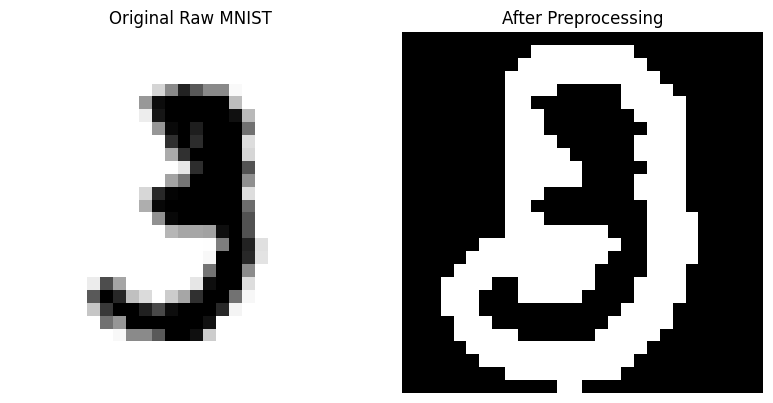

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# Display original digit
axes[0].imshow(raw_mnist_sample_2d_uint8, cmap='gray_r') # Or 'gray'
axes[0].set_title(f"Original Raw MNIST")
axes[0].axis('off')

# Display the processed digit 
axes[1].imshow(processed_flat_digit.reshape(28, 28), cmap='gray') 
axes[1].set_title("After Preprocessing")
axes[1].axis('off')

plt.tight_layout()
plt.show()


In [10]:
def adjust_brightness(image_2d_uint8, value=30):
    bright_image = np.clip(image_2d_uint8.astype(np.int16) + value, 0, 255).astype(np.uint8)
    return bright_image



Testing the brightness adjustment function

In [11]:
#Test brightness adjustment and the imported preprocessor 

sample_idx = 7 # Choose a sample
original_flat = X_mnist_raw[sample_idx]
original_2d_uint8 = original_flat.reshape(28, 28).astype(np.uint8)

# Make it brighter
brighter_digit = adjust_brightness(original_2d_uint8, value=70)
# Make it darker
darker_digit = adjust_brightness(original_2d_uint8, value=-70)

processed_original = preprocess_for_lighting(original_2d_uint8) 
processed_brighter = preprocess_for_lighting(brighter_digit) 
processed_darker = preprocess_for_lighting(darker_digit)   

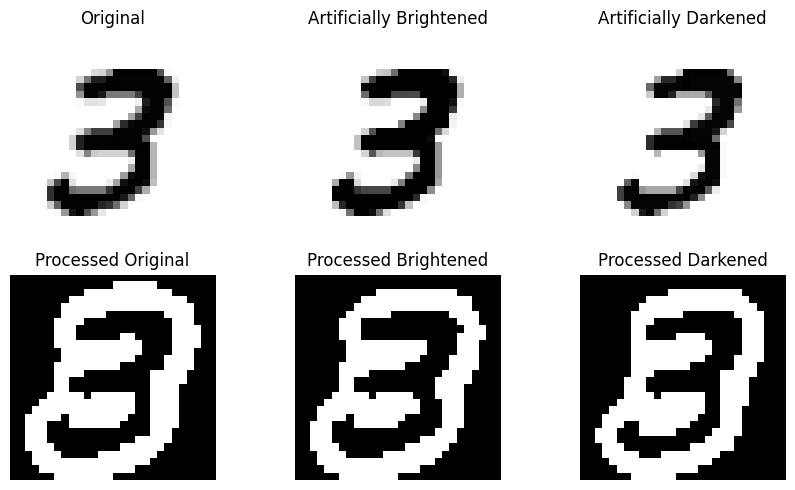

In [12]:
# Display
fig, axes = plt.subplots(2, 3, figsize=(9, 5))
    
axes[0,0].imshow(original_2d_uint8, cmap='gray_r')
axes[0,0].set_title(f"Original")
axes[0,0].axis('off')

axes[0,1].imshow(brighter_digit, cmap='gray_r')
axes[0,1].set_title("Artificially Brightened")
axes[0,1].axis('off')

axes[0,2].imshow(darker_digit, cmap='gray_r')
axes[0,2].set_title("Artificially Darkened")
axes[0,2].axis('off')


axes[1,0].imshow(processed_original.reshape(28,28), cmap='gray')
axes[1,0].set_title("Processed Original")
axes[1,0].axis('off')

axes[1,1].imshow(processed_brighter.reshape(28,28), cmap='gray')
axes[1,1].set_title("Processed Brightened")
axes[1,1].axis('off')
   
axes[1,2].imshow(processed_darker.reshape(28,28), cmap='gray')
axes[1,2].set_title("Processed Darkened")
axes[1,2].axis('off')
    
        
plt.tight_layout()
plt.show()

In [13]:
def adjust_contrast(image_2d_uint8, factor=1.5):
    
    image_float = image_2d_uint8.astype(np.float32)
    mean_intensity = 128.0 
    contrasted_image_float = factor * (image_float - mean_intensity) + mean_intensity #contrast adjustment: factor * (pixel - mean) + mean
    contrasted_image_uint8 = np.clip(contrasted_image_float, 0, 255).astype(np.uint8)
    
    return contrasted_image_uint8

Testing the contrast adjustment function

In [14]:
#Test contrast adjustment and the imported preprocessor

sample_idx = 7 # Choose a sample 
original_flat = X_mnist_raw[sample_idx]
original_2d_uint8 = original_flat.reshape(28, 28).astype(np.uint8)


higher_contrast_digit = adjust_contrast(original_2d_uint8, factor=2.0) # Increase contrast
lower_contrast_digit = adjust_contrast(original_2d_uint8, factor=0.5) # Decrease contrast

processed_original = preprocess_for_lighting(original_2d_uint8)
processed_higher_contrast = preprocess_for_lighting(higher_contrast_digit)
processed_lower_contrast = preprocess_for_lighting(lower_contrast_digit)

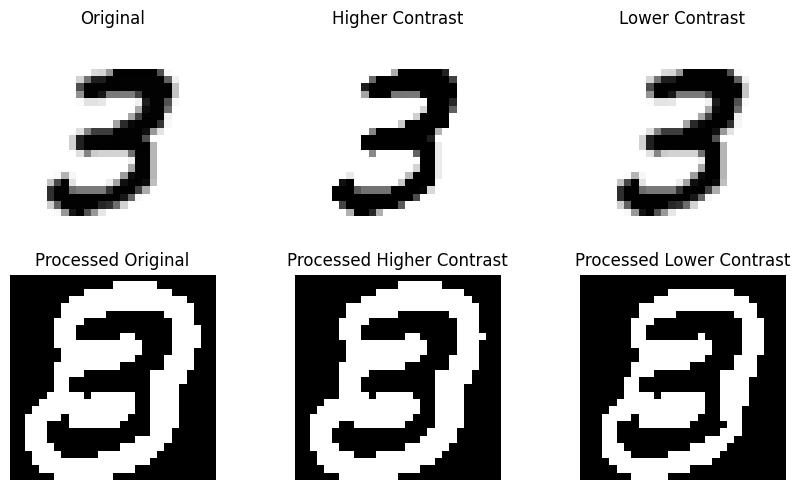

In [15]:
fig, axes = plt.subplots(2, 3, figsize=(9, 5))
    
axes[0,0].imshow(original_2d_uint8, cmap='gray_r')
axes[0,0].set_title(f"Original")
axes[0,0].axis('off')

axes[0,1].imshow(higher_contrast_digit, cmap='gray_r')
axes[0,1].set_title("Higher Contrast")
axes[0,1].axis('off')

axes[0,2].imshow(lower_contrast_digit, cmap='gray_r')
axes[0,2].set_title("Lower Contrast")
axes[0,2].axis('off')

axes[1,0].imshow(processed_original.reshape(28,28), cmap='gray')
axes[1,0].set_title("Processed Original")
axes[1,0].axis('off')

    
axes[1,1].imshow(processed_higher_contrast.reshape(28,28), cmap='gray')
axes[1,1].set_title("Processed Higher Contrast")
axes[1,1].axis('off')
   
   
axes[1,2].imshow(processed_lower_contrast.reshape(28,28), cmap='gray')
axes[1,2].set_title("Processed Lower Contrast")
axes[1,2].axis('off')

plt.tight_layout()
plt.show()

In [16]:
def augment_and_preprocess_image(raw_image_2d_uint8,
                                 augmentation_probability=0.75,
                                 brightness_range=(-80, 80),
                                 contrast_range=(0.5, 2.0)):
    augmented_image_for_viz = None # For visualizing the intermediate augmentation
    image_to_process = raw_image_2d_uint8.copy() # Start with a copy

    if random.random() < augmentation_probability:
        # Apply an augmentation
        augmentation_type = random.choice(['brightness', 'contrast'])

        if augmentation_type == 'brightness':
            b_value = random.randint(brightness_range[0], brightness_range[1])
            image_to_process = adjust_brightness(image_to_process, value=b_value)

        elif augmentation_type == 'contrast':
            c_factor = random.uniform(contrast_range[0], contrast_range[1])
            image_to_process = adjust_contrast(image_to_process, factor=c_factor)
        
        augmented_image_for_viz = image_to_process.copy() # Save for visualization

    final_processed_flat_image = preprocess_for_lighting(image_to_process)

    return final_processed_flat_image, augmented_image_for_viz

In [17]:
Testing the master augmentation pipeline

SyntaxError: invalid syntax (3073866063.py, line 1)

In [ ]:
# Testing master augmentation and preprocessing pipeline 

num_test_samples = 5
fig, axes = plt.subplots(num_test_samples, 3, figsize=(6, 3 * num_test_samples))
plt.suptitle("Master Augmentation & Preprocessing Pipeline Test", fontsize=16) 

for i in range(num_test_samples):
    sample_idx = random.randint(0, X_mnist_raw.shape[0] - 1) #random MNIST digit
    original_flat = X_mnist_raw[sample_idx]
    original_2d_uint8 = original_flat.reshape(28, 28).astype(np.uint8)
    
    # Apply the full pipeline
    processed_features, intermediate_augmented_viz = augment_and_preprocess_image(original_2d_uint8)

    # Plot original
    current_ax_orig = axes[i, 0]
    current_ax_orig.imshow(original_2d_uint8, cmap='gray_r')
    current_ax_orig.set_title(f"Original")
    current_ax_orig.axis('off')

    # Plot intermediate augmented 
    current_ax_aug = axes[i, 1]
    if intermediate_augmented_viz is not None:
        current_ax_aug.imshow(intermediate_augmented_viz, cmap='gray_r')
        current_ax_aug.set_title("Intermediate Augmentation")
    else:
        current_ax_aug.set_title("No Augmentation Applied")
    current_ax_aug.axis('off')

    # Plot final processed output
    current_ax_proc = axes[i, 2]
    
    current_ax_proc.imshow(processed_features.reshape(28, 28), cmap='gray')
    current_ax_proc.set_title("Final Processed for RF")

        

plt.tight_layout(rect=[0, 0, 1, 0.96]) 
plt.show()


#### Augmented Training Set Generation

In [18]:
# train - test - split

X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(
        X_mnist_raw,
        y_mnist,
        test_size=0.2,      
        random_state=42,    
        stratify=y_mnist    
    )

In [19]:
print(f"X_train_base shape: {X_train_base.shape}, y_train_base shape: {y_train_base.shape}")
print(f"X_test_base shape: {X_test_base.shape}, y_test_base shape: {y_test_base.shape}")


X_train_base shape: (56000, 784), y_train_base shape: (56000,)
X_test_base shape: (14000, 784), y_test_base shape: (14000,)


In [20]:
X_train_final_list = []
y_train_final_list = [] # copy of y_train_base

# Loop through each image in the base training set
for i in range(X_train_base.shape[0]):
    raw_image_flat = X_train_base[i]
    label = y_train_base[i]

    # Reshape to 2D and ensure uint8 type
    image_2d_uint8 = raw_image_flat.reshape(28, 28).astype(np.uint8)

    processed_features, _ = augment_and_preprocess_image(image_2d_uint8)

        
    X_train_final_list.append(processed_features)
    y_train_final_list.append(label)
    
    #Print progress
    if (i + 1) % 5000 == 0: # Print every 5000 images
        print(f"Processed {i + 1} / {X_train_base.shape[0]} images for training set...")

# Convert the lists to NumPy arrays
X_train_final = np.array(X_train_final_list)
y_train_final = np.array(y_train_final_list)

print(f"Shape of X_train_final: {X_train_final.shape}")
print(f"Shape of y_train_final: {y_train_final.shape}") 


Processed 5000 / 56000 images for training set...
Processed 10000 / 56000 images for training set...
Processed 15000 / 56000 images for training set...
Processed 20000 / 56000 images for training set...
Processed 25000 / 56000 images for training set...
Processed 30000 / 56000 images for training set...
Processed 35000 / 56000 images for training set...
Processed 40000 / 56000 images for training set...
Processed 45000 / 56000 images for training set...
Processed 50000 / 56000 images for training set...
Processed 55000 / 56000 images for training set...
Shape of X_train_final: (56000, 784)
Shape of y_train_final: (56000,)


only the robust preprocessing and no random augmentations for final test set

In [21]:
X_test_final_list = []
y_test_final_list = [] # This will essentially be a copy of y_test_base

# Loop through each image in the base test set
for i in range(X_test_base.shape[0]):
    raw_image_flat = X_test_base[i]
    label = y_test_base[i]

    # Reshape to 2D and ensure uint8 type
    image_2d_uint8 = raw_image_flat.reshape(28, 28).astype(np.uint8)

    processed_features = preprocess_for_lighting(image_2d_uint8) # Use your function name here

    if processed_features is not None:
        X_test_final_list.append(processed_features)
        y_test_final_list.append(label)
   
    #Print progress
    if (i + 1) % 2000 == 0: # Print every 2000 images 
        print(f"Processed {i + 1} / {X_test_base.shape[0]} images for test set...")

# Convert the lists to NumPy arrays
X_test_final = np.array(X_test_final_list)
y_test_final = np.array(y_test_final_list)

    
print(f"Shape of X_test_final: {X_test_final.shape}")
print(f"Shape of y_test_final: {y_test_final.shape}")

Processed 2000 / 14000 images for test set...
Processed 4000 / 14000 images for test set...
Processed 6000 / 14000 images for test set...
Processed 8000 / 14000 images for test set...
Processed 10000 / 14000 images for test set...
Processed 12000 / 14000 images for test set...
Processed 14000 / 14000 images for test set...
Shape of X_test_final: (14000, 784)
Shape of y_test_final: (14000,)


#### Model Development and Training

In [22]:
# Initialize the Random Forest Classifier
rf_classifier_final = RandomForestClassifier(n_estimators=100,
                                         random_state=42,
                                         n_jobs=-1, # Use all available cores
                                         verbose=1) # Set verbose to 1 to see some progress from RF

# Train the classifier
rf_classifier_final.fit(X_train_final, y_train_final)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.1s finished


RandomForestClassifier(n_jobs=-1, random_state=42, verbose=1)

#### Evaluation 

In [23]:
y_pred_final = rf_classifier_final.predict(X_test_final)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


In [25]:
#Accuracy Score
accuracy_final = metrics.accuracy_score(y_test_final, y_pred_final)
print(f"\nFinal Model Accuracy: {accuracy_final:.4f}")


Final Model Accuracy: 0.9590


In [27]:
#Classification Report
print("\nFinal Model Classification Report:")
print(metrics.classification_report(y_test_final, y_pred_final))


Final Model Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1381
           1       0.99      0.98      0.98      1575
           2       0.95      0.96      0.96      1398
           3       0.95      0.95      0.95      1428
           4       0.97      0.95      0.96      1365
           5       0.97      0.93      0.95      1263
           6       0.97      0.97      0.97      1375
           7       0.97      0.96      0.96      1459
           8       0.94      0.94      0.94      1365
           9       0.93      0.94      0.94      1391

    accuracy                           0.96     14000
   macro avg       0.96      0.96      0.96     14000
weighted avg       0.96      0.96      0.96     14000



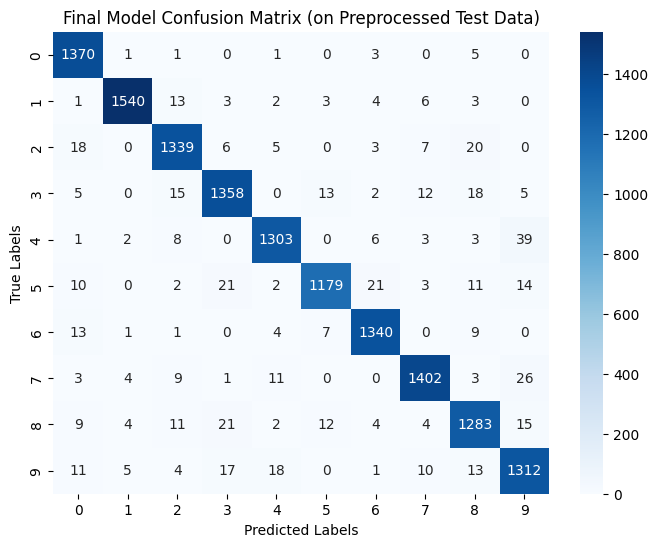

In [29]:
cm_final = metrics.confusion_matrix(y_test_final, y_pred_final)

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm_final, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Final Model Confusion Matrix (on Preprocessed Test Data)')
plt.show()

#### Exporting Model 

In [32]:
model_filename = 'saved_models/rf_robust_digit_classifier_v1.joblib' 
joblib.dump(rf_classifier_final, model_filename)

['saved_models/rf_robust_digit_classifier_v1.joblib']